<a href="https://colab.research.google.com/github/kyjness/Undergraduate-Research-Assistant/blob/main/4%EC%A3%BC%EC%B0%A8_Pytorch%EB%A1%9C_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%9E%85%EB%AC%B8(5_8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#05. [ML 입문] - 소프트맥스 회귀(Softmax Regression)

##05-01 원-핫 인코딩(One-Hot Encoding)

##05-02 소프트맥스 회귀(Softmax Regression) 이해하기

##05-03 소프트맥스 회귀 다양한 방법으로 구현하기

In [1]:
import torch
import torch.nn.functional as F
torch.manual_seed(1)

###1. 소프트맥스 회귀의 비용 함수 구현

1) 파이토치로 소프트맥스의 비용 함수 구현하기 (로우-레벨)

In [2]:
z = torch.FloatTensor([1, 2, 3])
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [3]:
hypothesis.sum()

tensor(1.)

In [4]:
z = torch.rand(3, 5, requires_grad=True)
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [5]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 2, 1])


In [6]:
# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [7]:
print(y.unsqueeze(1))

tensor([[0],
        [2],
        [1]])


In [8]:
print(y_one_hot)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])


In [9]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


2) 파이토치로 소프트맥스의 비용 함수 구현하기 (하이-레벨)

In [10]:
# Low level
torch.log(F.softmax(z, dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

In [11]:
# High level
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

In [12]:
# Low level
# 첫번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [13]:
# 두번째 수식
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [14]:
# High level
# 세번째 수식
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

In [15]:
# 네번째 수식
F.cross_entropy(z, y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

###2. 소프트맥스 회귀 구현하기

1) 데이터셋 준비

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

In [17]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

2) 소프트맥스 회귀 구현하기(로우-레벨)

In [18]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [19]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 3])


In [20]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

In [21]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1)

    # 비용 함수
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704199
Epoch  200/1000 Cost: 0.622999
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467661
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285072
Epoch 1000/1000 Cost: 0.248155


3) 소프트맥스 회귀 구현하기(하이-레벨)

In [22]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704199
Epoch  200/1000 Cost: 0.623000
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


4) 소프트맥스 회귀 nn.Module로 구현하기

In [23]:
# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)

In [24]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.616785
Epoch  100/1000 Cost: 0.658891
Epoch  200/1000 Cost: 0.573443
Epoch  300/1000 Cost: 0.518151
Epoch  400/1000 Cost: 0.473265
Epoch  500/1000 Cost: 0.433516
Epoch  600/1000 Cost: 0.396563
Epoch  700/1000 Cost: 0.360914
Epoch  800/1000 Cost: 0.325392
Epoch  900/1000 Cost: 0.289178
Epoch 1000/1000 Cost: 0.254148


5) 소프트맥스 회귀 클래스로 구현하기

In [25]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

In [26]:
model = SoftmaxClassifierModel()

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [27]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 2.637636
Epoch  100/1000 Cost: 0.647903
Epoch  200/1000 Cost: 0.564643
Epoch  300/1000 Cost: 0.511043
Epoch  400/1000 Cost: 0.467249
Epoch  500/1000 Cost: 0.428280
Epoch  600/1000 Cost: 0.391924
Epoch  700/1000 Cost: 0.356742
Epoch  800/1000 Cost: 0.321577
Epoch  900/1000 Cost: 0.285617
Epoch 1000/1000 Cost: 0.250818


##05-04 소프트맥스 회귀로 MNIST 데이터 분류하기

###3. 분류기 구현을 위한 사전 설정

In [29]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [30]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [31]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [32]:
# hyperparameters
training_epochs = 15
batch_size = 100

###4. MNIST 분류기 구현하기

In [33]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 58497030.17it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2442301.13it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14315681.46it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9421626.49it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [34]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

In [35]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

In [36]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [37]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577775
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307107031
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874764
Epoch: 0015 cost = 0.274422795
Learning finished


Accuracy: 0.8883000016212463
Label:  8
Prediction:  3


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


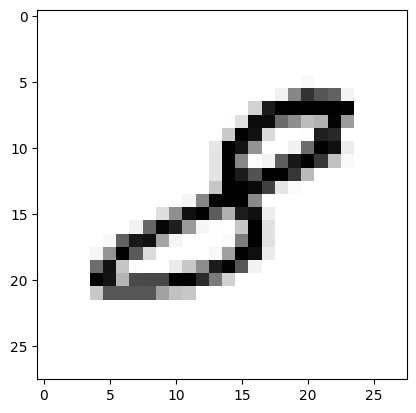

In [38]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

#06. [DL 입문] - 인공 신경망(Artificial Neural Network)

##06-01 머신 러닝 기본 개념 정리하기

###7. 비선형 활성화 함수

In [39]:
import numpy as np # 넘파이 사용
import matplotlib.pyplot as plt # 맷플롯립 사용

2) 시그모이드 함수(Sigmoid function)와 기울기 소실

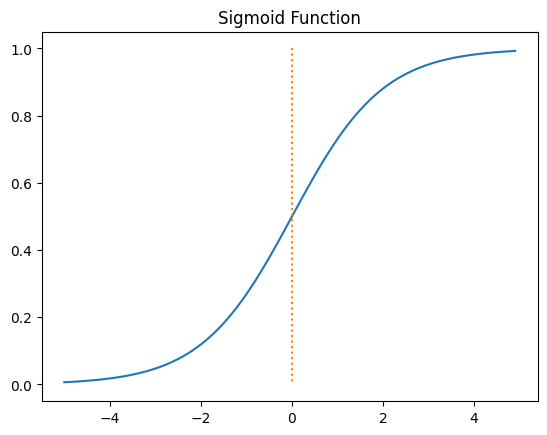

In [40]:
# 시그모이드 함수 그래프를 그리는 코드
def sigmoid(x):
    return 1/(1+np.exp(-x))
x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)

plt.plot(x, y)
plt.plot([0,0],[1.0,0.0], ':') # 가운데 점선 추가
plt.title('Sigmoid Function')
plt.show()

3) 하이퍼볼릭탄젠트 함수(Hyperbolic tangent function)

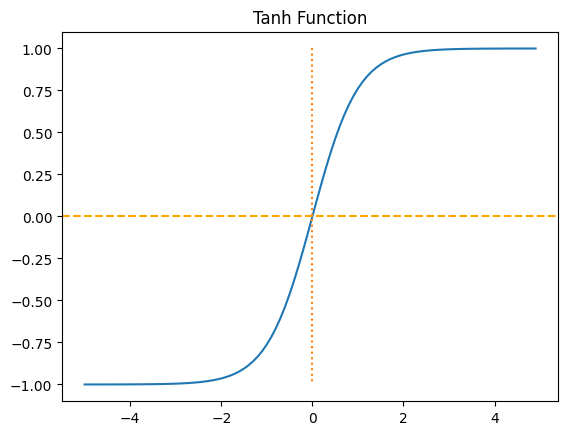

In [41]:
x = np.arange(-5.0, 5.0, 0.1) # -5.0부터 5.0까지 0.1 간격 생성
y = np.tanh(x)

plt.plot(x, y)
plt.plot([0,0],[1.0,-1.0], ':')
plt.axhline(y=0, color='orange', linestyle='--')
plt.title('Tanh Function')
plt.show()

4) 렐루 함수(ReLU)

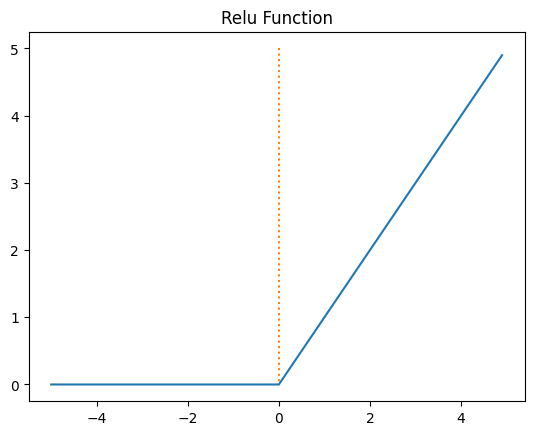

In [42]:
def relu(x):
    return np.maximum(0, x)

x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)

plt.plot(x, y)
plt.plot([0,0],[5.0,0.0], ':')
plt.title('Relu Function')
plt.show()

5) 리키 렐루(Leaky ReLU)

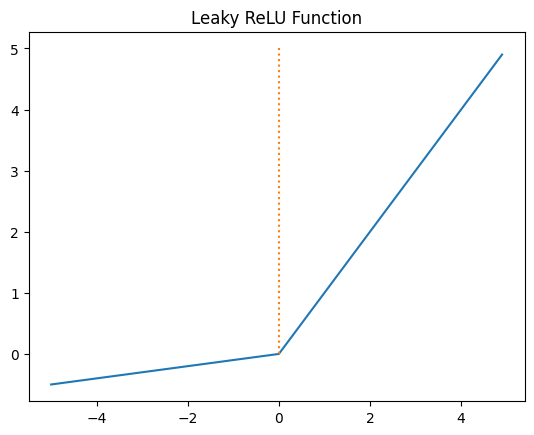

In [43]:
a = 0.1

def leaky_relu(x):
    return np.maximum(a*x, x)

x = np.arange(-5.0, 5.0, 0.1)
y = leaky_relu(x)

plt.plot(x, y)
plt.plot([0,0],[5.0,0.0], ':')
plt.title('Leaky ReLU Function')
plt.show()

6) 소프트맥스 함수(Softamx function)

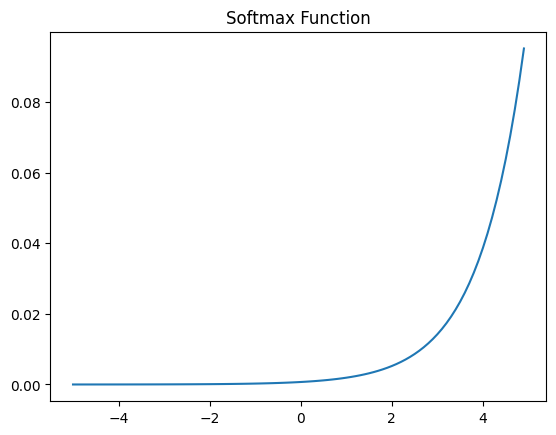

In [44]:
x = np.arange(-5.0, 5.0, 0.1) # -5.0부터 5.0까지 0.1 간격 생성
y = np.exp(x) / np.sum(np.exp(x))

plt.plot(x, y)
plt.title('Softmax Function')
plt.show()

7) 출력층의 활성화 함수와 오차 함수의 관계

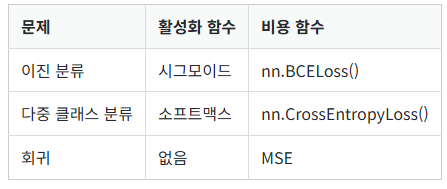

##06-02 퍼셉트론(Perceptron)

###2. 단층 퍼셉트론(Single-Layer Perceptron)

In [45]:
def AND_gate(x1, x2):
    w1=0.5
    w2=0.5
    b=-0.7
    result = x1*w1 + x2*w2 + b
    if result <= 0:
        return 0
    else:
        return 1

In [46]:
AND_gate(0, 0), AND_gate(0, 1), AND_gate(1, 0), AND_gate(1, 1)

(0, 0, 0, 1)

In [47]:
def NAND_gate(x1, x2):
    w1=-0.5
    w2=-0.5
    b=0.7
    result = x1*w1 + x2*w2 + b
    if result <= 0:
        return 0
    else:
        return 1

In [48]:
NAND_gate(0, 0), NAND_gate(0, 1), NAND_gate(1, 0), NAND_gate(1, 1)

(1, 1, 1, 0)

In [49]:
def OR_gate(x1, x2):
    w1=0.6
    w2=0.6
    b=-0.5
    result = x1*w1 + x2*w2 + b
    if result <= 0:
        return 0
    else:
        return 1

In [50]:
OR_gate(0, 0), OR_gate(0, 1), OR_gate(1, 0), OR_gate(1, 1)

(0, 1, 1, 1)

##06-03 XOR 문제 구현하기 - 단층 퍼셉트론과 다층 퍼셉트론

###1. 파이토치로 단층 퍼셉트론 구현하기

In [51]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

1) 단층 퍼셉트론을 이용한 XOR 문제 풀기

In [52]:
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

In [53]:
linear = nn.Linear(2, 1, bias=True)
sigmoid = nn.Sigmoid()
model = nn.Sequential(linear, sigmoid).to(device)

In [54]:
# 비용 함수와 옵티마이저 정의
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [55]:
for step in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    # 비용 함수
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 100 == 0: # 100번째 에포크마다 비용 출력
        print(step, cost.item())

0 0.7273973822593689
100 0.6931476593017578
200 0.6931471824645996
300 0.6931471824645996
400 0.6931471824645996
500 0.6931471824645996
600 0.6931471824645996
700 0.6931471824645996
800 0.6931471824645996
900 0.6931471824645996
1000 0.6931471824645996
1100 0.6931471824645996
1200 0.6931471824645996
1300 0.6931471824645996
1400 0.6931471824645996
1500 0.6931471824645996
1600 0.6931471824645996
1700 0.6931471824645996
1800 0.6931471824645996
1900 0.6931471824645996
2000 0.6931471824645996
2100 0.6931471824645996
2200 0.6931471824645996
2300 0.6931471824645996
2400 0.6931471824645996
2500 0.6931471824645996
2600 0.6931471824645996
2700 0.6931471824645996
2800 0.6931471824645996
2900 0.6931471824645996
3000 0.6931471824645996
3100 0.6931471824645996
3200 0.6931471824645996
3300 0.6931471824645996
3400 0.6931471824645996
3500 0.6931471824645996
3600 0.6931471824645996
3700 0.6931471824645996
3800 0.6931471824645996
3900 0.6931471824645996
4000 0.6931471824645996
4100 0.6931471824645996
4200

2) 학습된 단층 퍼셉트론의 예측값 확인하기

In [56]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', Y.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item())

모델의 출력값(Hypothesis):  [[0.5]
 [0.5]
 [0.5]
 [0.5]]
모델의 예측값(Predicted):  [[0.]
 [0.]
 [0.]
 [0.]]
실제값(Y):  [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy):  0.5


###2. 파이토치로 다층 퍼셉트론 구현하기

In [58]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

1) 다층 퍼셉트론을 이용한 XOR 문제 풀기

In [59]:
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

In [60]:
model = nn.Sequential(
          nn.Linear(2, 10, bias=True), # input_layer = 2, hidden_layer1 = 10
          nn.Sigmoid(),
          nn.Linear(10, 10, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
          nn.Sigmoid(),
          nn.Linear(10, 10, bias=True), # hidden_layer2 = 10, hidden_layer3 = 10
          nn.Sigmoid(),
          nn.Linear(10, 1, bias=True), # hidden_layer3 = 10, output_layer = 1
          nn.Sigmoid()
          ).to(device)

In [61]:
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

In [62]:
for epoch in range(10001):
    optimizer.zero_grad()
    # forward 연산
    hypothesis = model(X)

    # 비용 함수
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    # 100의 배수에 해당되는 에포크마다 비용을 출력
    if epoch % 100 == 0:
        print(epoch, cost.item())

0 0.6948983073234558
100 0.693155825138092
200 0.6931535601615906
300 0.6931513547897339
400 0.6931493282318115
500 0.6931473016738892
600 0.6931453943252563
700 0.6931434869766235
800 0.6931416988372803
900 0.6931397914886475
1000 0.6931379437446594
1100 0.6931361556053162
1200 0.6931343078613281
1300 0.6931324005126953
1400 0.6931304931640625
1500 0.6931284666061401
1600 0.6931264400482178
1700 0.6931242942810059
1800 0.6931220293045044
1900 0.6931197047233582
2000 0.6931172609329224
2100 0.6931145191192627
2200 0.6931115984916687
2300 0.6931084990501404
2400 0.6931051015853882
2500 0.6931014657020569
2600 0.6930974721908569
2700 0.6930930018424988
2800 0.6930879950523376
2900 0.6930825114250183
3000 0.6930762529373169
3100 0.6930692195892334
3200 0.6930612325668335
3300 0.6930519938468933
3400 0.6930411458015442
3500 0.6930283904075623
3600 0.6930132508277893
3700 0.6929951906204224
3800 0.6929728984832764
3900 0.6929453015327454
4000 0.6929103136062622
4100 0.6928649544715881
4200 

2) 학습된 다층 퍼셉트론의 예측값 확인하기

In [63]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', Y.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item())

모델의 출력값(Hypothesis):  [[1.1168801e-04]
 [9.9982882e-01]
 [9.9984229e-01]
 [1.8529482e-04]]
모델의 예측값(Predicted):  [[0.]
 [1.]
 [1.]
 [0.]]
실제값(Y):  [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy):  1.0


##06-04 역전파(BackPropagation)

##06-05 다층 퍼셉트론으로 손글씨 분류하기

###1. 숫자 필기 데이터 소개

In [65]:
import matplotlib.pyplot as plt # 시각화를 위한 맷플롯립
from sklearn.datasets import load_digits
digits = load_digits() # 1,979개의 이미지 데이터 로드

print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [66]:
print(digits.target[0])

0


In [67]:
print('전체 샘플의 수 : {}'.format(len(digits.images)))

전체 샘플의 수 : 1797


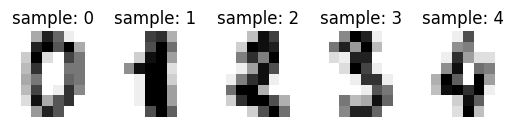

In [68]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:5]): # 5개의 샘플만 출력
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('sample: %i' % label)

In [69]:
for i in range(5):
  print(i,'번 인덱스 샘플의 레이블 : ',digits.target[i])

0 번 인덱스 샘플의 레이블 :  0
1 번 인덱스 샘플의 레이블 :  1
2 번 인덱스 샘플의 레이블 :  2
3 번 인덱스 샘플의 레이블 :  3
4 번 인덱스 샘플의 레이블 :  4


In [70]:
print(digits.data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [71]:
X = digits.data # 이미지. 즉, 특성 행렬
Y = digits.target # 각 이미지에 대한 레이블

###2. 다층 퍼셉트론 분류기 만들기

In [72]:
import torch
import torch.nn as nn
from torch import optim

In [73]:
# 모델 정의: 순차적인 레이어 구조
model = nn.Sequential(
    nn.Linear(64, 32), # 입력층: 64, 첫 번째 은닉층: 32
    nn.ReLU(),         # 활성화 함수: ReLU
    nn.Linear(32, 16), # 첫 번째 은닉층: 32, 두 번째 은닉층: 16
    nn.ReLU(),         # 활성화 함수: ReLU
    nn.Linear(16, 10)  # 두 번째 은닉층: 16, 출력층: 10 (클래스의 개수)
)

In [76]:
# 입력 데이터 X와 레이블 Y를 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)

loss_fn = nn.CrossEntropyLoss() # 이 비용 함수는 소프트맥스 함수를 포함하고 있음.

optimizer = optim.Adam(model.parameters())

losses = []

<ipython-input-76-ca1dc1a31ea3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-76-ca1dc1a31ea3>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.int64)


In [77]:
# 총 100번의 에포크 동안 모델 학습
for epoch in range(100):
  optimizer.zero_grad()      # 옵티마이저의 기울기 초기화
  y_pred = model(X)          # 순전파 연산으로 예측값 계산
  loss = loss_fn(y_pred, Y)  # 손실 함수로 비용 계산
  loss.backward()            # 역전파 연산으로 기울기 계산
  optimizer.step()           # 옵티마이저를 통해 파라미터 업데이트

  # 10번째 에포크마다 현재 에포크와 손실 값 출력
  if epoch % 10 == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, 100, loss.item()
        ))

  # 손실 값을 리스트에 추가하여 추적
  losses.append(loss.item())

Epoch    0/100 Cost: 2.381846
Epoch   10/100 Cost: 2.086940
Epoch   20/100 Cost: 1.844468
Epoch   30/100 Cost: 1.555474
Epoch   40/100 Cost: 1.246410
Epoch   50/100 Cost: 0.968091
Epoch   60/100 Cost: 0.724376
Epoch   70/100 Cost: 0.519714
Epoch   80/100 Cost: 0.380597
Epoch   90/100 Cost: 0.293385


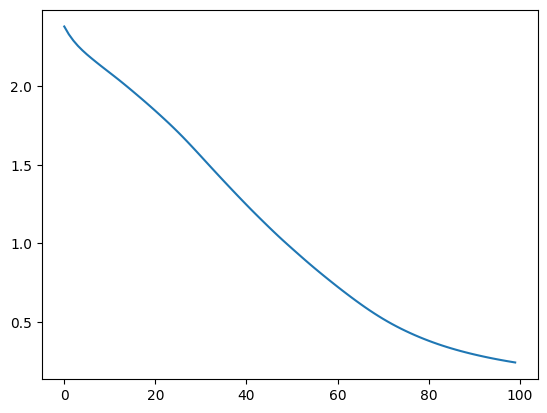

In [78]:
plt.plot(losses)

##06-06 다층 퍼셉트론으로 MNIST 분류하기

###1. 데이터 로드하기

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [80]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

In [81]:
mnist.data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [82]:
mnist.target[0]

'5'

In [83]:
mnist.target = mnist.target.astype(np.int8)

In [84]:
X = mnist.data / 255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target

In [85]:
X[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [86]:
y[0]

5

이 이미지 데이터의 레이블은 5이다


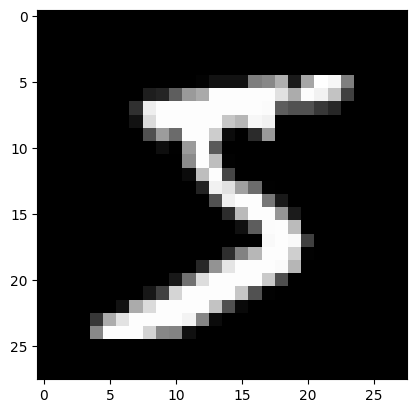

In [87]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 레이블은 {:.0f}이다".format(y[0]))

###2. 훈련 데이터와 테스트 데이터의 분리

In [88]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

In [90]:
# 텐서로 변환
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# TensorDataset 객체 생성
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader 객체 생성
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

###3. 다층 퍼셉트론

In [91]:
from torch import nn
from torch import optim

In [92]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [93]:
# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [94]:
# 총 3번의 에포크 동안 모델 학습
epochs = 3

for epoch in range(epochs):
  for data, targets in loader_train:
    optimizer.zero_grad()      # 옵티마이저의 기울기 초기화
    y_pred = model(data)          # 순전파 연산으로 예측값 계산
    loss = loss_fn(y_pred, targets)  # 손실 함수로 비용 계산
    loss.backward()            # 역전파 연산으로 기울기 계산
    optimizer.step()           # 옵티마이저를 통해 파라미터 업데이트

  print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch + 1, 3, loss.item()))

Epoch    1/3 Cost: 0.657048
Epoch    2/3 Cost: 0.168507
Epoch    3/3 Cost: 0.253673


In [95]:
model.eval()  # 신경망을 추론 모드로 전환
correct = 0

# 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
with torch.no_grad():  # 추론 과정에는 미분이 필요없음
    for data, targets in loader_test:

        outputs = model(data)  # 데이터를 입력하고 출력을 계산

        # 추론 계산
        _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
        correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

# 정확도 출력
data_num = len(loader_test.dataset)  # 데이터 총 건수
print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100. * correct / data_num))


테스트 데이터에서 예측 정확도: 9512/10000 (95%)



예측 결과 : 2
이 이미지 데이터의 정답 레이블은 2입니다


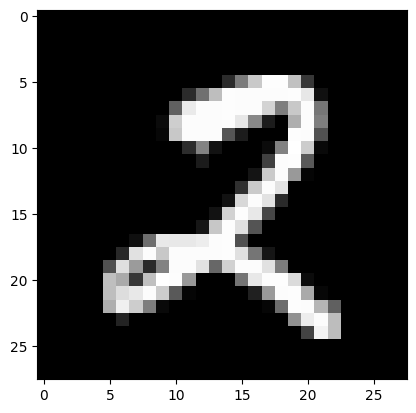

In [96]:
index = 2018

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))

##06-07 과적합(Overfitting)을 막는 방법들

###2. 모델의 복잡도 줄이기

In [97]:
class Architecture1(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Architecture1, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.relu = nnReLU()
    self.fc3 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out

In [98]:
class Architecture1(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Architecture1, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

###3. 가중치 규제(Regularization) 적용하기

In [99]:
model = Architecture1(10, 20, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

##06-08 기울기 소실(Gradient Vanishing)과 폭주(Exploding)

#07. [DL 입문] - 순환 신경망(Recurrent Neural Network)

##07-01 순환 신경망(Recurrent Neural Network, RNN)

###2. 파이썬으로 RNN 구현하기

In [101]:
import numpy as np

timesteps = 10 # 시점의 수. NLP에서는 보통 문장의 길이가 된다.
input_size = 4 # 입력의 차원. NLP에서는 보통 단어 벡터의 차원이 된다.
hidden_size = 8 # 은닉 상태의 크기. 메모리 셀의 용량이다.

inputs = np.random.random((timesteps, input_size)) # 입력에 해당되는 2D 텐서

hidden_state_t = np.zeros((hidden_size,)) # 초기 은닉 상태는 0(벡터)로 초기화
# 은닉 상태의 크기 hidden_size로 은닉 상태를 만듬.

In [102]:
print(hidden_state_t) # 8의 크기를 가지는 은닉 상태. 현재는 초기 은닉 상태로 모든 차원이 0의 값을 가짐.

[0. 0. 0. 0. 0. 0. 0. 0.]


In [103]:
Wx = np.random.random((hidden_size, input_size))  # (8, 4)크기의 2D 텐서 생성. 입력에 대한 가중치.
Wh = np.random.random((hidden_size, hidden_size)) # (8, 8)크기의 2D 텐서 생성. 은닉 상태에 대한 가중치.
b = np.random.random((hidden_size,)) # (8,)크기의 1D 텐서 생성. 이 값은 편향(bias).

In [104]:
print(np.shape(Wx))
print(np.shape(Wh))
print(np.shape(b))

(8, 4)
(8, 8)
(8,)


In [105]:
total_hidden_states = []

# 메모리 셀 동작
for input_t in inputs: # 각 시점에 따라서 입력값이 입력됨.
  output_t = np.tanh(np.dot(Wx,input_t) + np.dot(Wh,hidden_state_t) + b) # Wx * Xt + Wh * Ht-1 + b(bias)
  total_hidden_states.append(list(output_t)) # 각 시점의 은닉 상태의 값을 계속해서 축적
  print(np.shape(total_hidden_states)) # 각 시점 t별 메모리 셀의 출력의 크기는 (timestep, output_dim)
  hidden_state_t = output_t

total_hidden_states = np.stack(total_hidden_states, axis = 0)
# 출력 시 값을 깔끔하게 해준다.

print(total_hidden_states) # (timesteps, output_dim)의 크기. 이 경우 (10, 8)의 크기를 가지는 메모리 셀의 2D 텐서를 출력.

(1, 8)
(2, 8)
(3, 8)
(4, 8)
(5, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)
[[0.75536588 0.92094415 0.86900587 0.90898796 0.96593322 0.68002514
  0.87617161 0.89725047]
 [0.9999725  0.99993897 0.99925073 0.99994414 0.99999545 0.99956928
  0.99999587 0.99994614]
 [0.99998901 0.99997007 0.99957616 0.99996226 0.99999812 0.99977872
  0.99999822 0.99997334]
 [0.99998651 0.99994719 0.99928053 0.99996117 0.99999628 0.99967222
  0.99999684 0.99996983]
 [0.99996578 0.99989155 0.99870818 0.99986581 0.99998643 0.99936935
  0.99998846 0.99989055]
 [0.99999532 0.99998146 0.99978772 0.99999036 0.99999923 0.99983924
  0.99999944 0.99998996]
 [0.99999098 0.99996765 0.99974152 0.99998856 0.99999826 0.99979369
  0.999999   0.99998365]
 [0.99998961 0.99997517 0.99967461 0.99996555 0.99999849 0.999805
  0.9999986  0.99997392]
 [0.99998834 0.99994493 0.99948851 0.9999614  0.99999514 0.99947119
  0.99999681 0.99994861]
 [0.99998023 0.99995983 0.99953402 0.99988246 0.9999957  0.99960662
  0.99999593 0.99990205]]


###3. 파이토치의 nn.RNN()

In [106]:
import torch
import torch.nn as nn

In [107]:
input_size = 5 # 입력의 크기
hidden_size = 8 # 은닉 상태의 크기

In [108]:
# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1, 10, 5)

In [109]:
cell = nn.RNN(input_size, hidden_size, batch_first=True)

In [110]:
outputs, _status = cell(inputs)

In [111]:
print(outputs.shape) # 모든 time-step의 hidden_state

torch.Size([1, 10, 8])


In [112]:
print(_status.shape) # 최종 time-step의 hidden_state

torch.Size([1, 1, 8])


###4. 깊은 순환 신경망(Deep Recurrent Neural Network)

In [113]:
# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1, 10, 5)

In [114]:
cell = nn.RNN(input_size = 5, hidden_size = 8, num_layers = 2, batch_first=True)

In [115]:
print(outputs.shape) # 모든 time-step의 hidden_state

torch.Size([1, 10, 8])


In [116]:
print(_status.shape) # (층의 개수, 배치 크기, 은닉 상태의 크기)

torch.Size([1, 1, 8])


###5. 양방향 순환 신경망(Bidirectional Recurrent Neural Network)

In [117]:
# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1, 10, 5)

In [118]:
cell = nn.RNN(input_size = 5, hidden_size = 8, num_layers = 2, batch_first=True, bidirectional = True)

In [119]:
outputs, _status = cell(inputs)

In [120]:
print(outputs.shape) # (배치 크기, 시퀀스 길이, 은닉 상태의 크기 x 2)

torch.Size([1, 10, 16])


In [121]:
print(_status.shape) # (층의 개수 x 2, 배치 크기, 은닉 상태의 크기)

torch.Size([4, 1, 8])


##07-02 LSTM과 GRU

##07-03 문자 단위 RNN(Char RNN): 실습 2개

###1. 문자 단위 RNN(Char RNN)

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

1) 훈련 데이터 전처리하기

In [123]:
input_str = 'apple'
label_str = 'pple!'
char_vocab = sorted(list(set(input_str+label_str)))
vocab_size = len(char_vocab)
print ('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합의 크기 : 5


In [124]:
input_size = vocab_size # 입력의 크기는 문자 집합의 크기
hidden_size = 5
output_size = 5
learning_rate = 0.1

In [125]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab)) # 문자에 고유한 정수 인덱스 부여
print(char_to_index)

{'!': 0, 'a': 1, 'e': 2, 'l': 3, 'p': 4}


In [126]:
index_to_char={}
for key, value in char_to_index.items():
    index_to_char[value] = key
print(index_to_char)

{0: '!', 1: 'a', 2: 'e', 3: 'l', 4: 'p'}


In [127]:
x_data = [char_to_index[c] for c in input_str]
y_data = [char_to_index[c] for c in label_str]
print(x_data)
print(y_data)

[1, 4, 4, 3, 2]
[4, 4, 3, 2, 0]


In [128]:
# 배치 차원 추가
# 텐서 연산인 unsqueeze(0)를 통해 해결할 수도 있었음.
x_data = [x_data]
y_data = [y_data]
print(x_data)
print(y_data)

[[1, 4, 4, 3, 2]]
[[4, 4, 3, 2, 0]]


In [129]:
x_one_hot = [np.eye(vocab_size)[x] for x in x_data]
print(x_one_hot)

[array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])]


In [130]:
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

<ipython-input-130-c1bfbd518a63>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.FloatTensor(x_one_hot)


In [131]:
print('훈련 데이터의 크기 : {}'.format(X.shape))
print('레이블의 크기 : {}'.format(Y.shape))

훈련 데이터의 크기 : torch.Size([1, 5, 5])
레이블의 크기 : torch.Size([1, 5])


2) 모델 구현하기

In [132]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True) # RNN 셀 구현
        self.fc = torch.nn.Linear(hidden_size, output_size, bias=True) # 출력층 구현

    def forward(self, x): # 구현한 RNN 셀과 출력층을 연결
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [133]:
net = Net(input_size, hidden_size, output_size)

In [134]:
outputs = net(X)
print(outputs.shape) # 3차원 텐서

torch.Size([1, 5, 5])


In [135]:
print(outputs.view(-1, input_size).shape) # 2차원 텐서로 변환

torch.Size([5, 5])


In [136]:
print(Y.shape)
print(Y.view(-1).shape)

torch.Size([1, 5])
torch.Size([5])


In [137]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [138]:
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, input_size), Y.view(-1)) # view를 하는 이유는 Batch 차원 제거를 위해
    loss.backward() # 기울기 계산
    optimizer.step() # 아까 optimizer 선언 시 넣어둔 파라미터 업데이트

    # 아래 세 줄은 모델이 실제 어떻게 예측했는지를 확인하기 위한 코드.
    result = outputs.data.numpy().argmax(axis=2) # 최종 예측값인 각 time-step 별 5차원 벡터에 대해서 가장 높은 값의 인덱스를 선택
    result_str = ''.join([index_to_char[c] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

0 loss:  1.612571358680725 prediction:  [[2 2 2 2 2]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  eeeee
1 loss:  1.3512823581695557 prediction:  [[4 4 4 4 4]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  ppppp
2 loss:  1.169076681137085 prediction:  [[4 4 4 4 4]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  ppppp
3 loss:  0.9465969204902649 prediction:  [[4 4 3 2 4]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplep
4 loss:  0.7213229537010193 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
5 loss:  0.5183435082435608 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
6 loss:  0.36363649368286133 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
7 loss:  0.2524997591972351 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
8 loss:  0.17788544297218323 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
9 loss:  0.1294630616903305 prediction:  [[4 4 3 2 0]] 

###2. 더 많은 데이터로 학습한 문자 단위 RNN(Char RNN)

In [139]:
import torch
import torch.nn as nn
import torch.optim as optim

1) 훈련 데이터 전처리하기

In [140]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [141]:
char_set = list(set(sentence)) # 중복을 제거한 문자 집합 생성
char_dic = {c: i for i, c in enumerate(char_set)} # 각 문자에 정수 인코딩

In [142]:
print(char_dic) # 공백도 여기서는 하나의 원소

{"'": 0, 'p': 1, 't': 2, 'k': 3, 'g': 4, 'c': 5, ' ': 6, 'h': 7, '.': 8, 's': 9, 'l': 10, 'i': 11, ',': 12, 'a': 13, 'b': 14, 'u': 15, 'f': 16, 'o': 17, 'n': 18, 'y': 19, 'w': 20, 'd': 21, 'm': 22, 'e': 23, 'r': 24}


In [143]:
dic_size = len(char_dic)
print('문자 집합의 크기 : {}'.format(dic_size))

문자 집합의 크기 : 25


In [144]:
# 하이퍼파라미터 설정
hidden_size = dic_size
sequence_length = 10  # 임의 숫자 지정
learning_rate = 0.1

In [145]:
# 데이터 구성
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [146]:
print(x_data[0])
print(y_data[0])

[11, 16, 6, 19, 17, 15, 6, 20, 13, 18]
[16, 6, 19, 17, 15, 6, 20, 13, 18, 2]


In [147]:
x_one_hot = [np.eye(dic_size)[x] for x in x_data] # x 데이터는 원-핫 인코딩
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [148]:
print('훈련 데이터의 크기 : {}'.format(X.shape))
print('레이블의 크기 : {}'.format(Y.shape))

훈련 데이터의 크기 : torch.Size([170, 10, 25])
레이블의 크기 : torch.Size([170, 10])


In [149]:
print(X[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [150]:
print(Y[0])

tensor([16,  6, 19, 17, 15,  6, 20, 13, 18,  2])


2) 모델 구현하기

In [151]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers): # 현재 hidden_size는 dic_size와 같음.
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [152]:
net = Net(dic_size, hidden_size, 2) # 이번에는 층을 두 개 쌓습니다.

In [153]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [154]:
outputs = net(X)
print(outputs.shape) # 3차원 텐서

torch.Size([170, 10, 25])


In [155]:
print(outputs.view(-1, dic_size).shape) # 2차원 텐서로 변환.

torch.Size([1700, 25])


In [156]:
print(Y.shape)
print(Y.view(-1).shape)

torch.Size([170, 10])
torch.Size([1700])


In [157]:
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X) # (170, 10, 25) 크기를 가진 텐서를 매 에포크마다 모델의 입력으로 사용
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    # results의 텐서 크기는 (170, 10)
    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        if j == 0: # 처음에는 예측 결과를 전부 가져오지만
            predict_str += ''.join([char_set[t] for t in result])
        else: # 그 다음에는 마지막 글자만 반복 추가
            predict_str += char_set[result[-1]]

    print(predict_str)

ssstssssstst nssss    tstss   sstst sss  sss st  tsnssstssssss st s stssss  t   sstststst  t ns   st ttst   ssstsssstssss sssssts snss sss ss t ssssts  t   ttt    ttt t sss ns  ss
                                                                                                                                                                                   
sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
ndhddddddddhhdhdddddhddhdhddhhddddhhdddddddddddddhhdddhddddhdhdddddddhdddhhddhhhddddhdddhdddhddddhddddhddhhdddddddddhdddddddhdddddhddddhdhdddddhdddhddhddhdddddhdddddhddhddhhddhhdd
n  ...hll         ll                                l  l l l      lnl  n                           l  ll                      l  nll    ll  lnlll       l ll                    n l
   ol   olollllllllllollllllllllllllolllllllllllllllllllllllllllllolllllllllllllllolllolllllllllllll

#08. [DL 입문] - 합성곱 신경망(Convolutional Neural Network)

##08-01 합성곱과 풀링(Convolution and Pooling)

##08-02 CNN으로 MNIST 분류하기

###2. 모델 구현하기

1) 필요한 도구 임포트와 입력의 정의

In [158]:
import torch
import torch.nn as nn

In [159]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([1, 1, 28, 28])


2) 합성곱층과 풀링 선언하기

In [160]:
conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [161]:
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [162]:
pool = nn.MaxPool2d(2)
print(pool)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


3) 구현체를 연결하여 모델 만들기

In [163]:
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [164]:
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [165]:
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [166]:
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [167]:
out.size(0)

1

In [168]:
out.size(1)

64

In [169]:
out.size(2)

7

In [170]:
out.size(3)

7

In [171]:
# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
out = out.view(out.size(0), -1)
print(out.shape)

torch.Size([1, 3136])


In [172]:
fc = nn.Linear(3136, 10) # input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape)

torch.Size([1, 10])


###3. CNN으로 MNIST 분류하기

In [173]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [174]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [175]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [176]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

In [177]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [178]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [179]:
# CNN 모델 정의
model = CNN().to(device)

In [180]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [181]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


In [ ]:
for epoch in range(training_epochs):
    avg_cost = 0  # 에포크당 평균 비용을 저장하기 위한 변수 초기화

    for X, Y in data_loader:  # 미니 배치 단위로 데이터를 꺼내옴. X는 입력 데이터, Y는 레이블
        # 이미지 데이터는 이미 (28x28) 크기를 가지므로, 별도의 reshape 필요 없음
        # 레이블 Y는 원-핫 인코딩이 아닌 정수형 클래스 레이블임
        X = X.to(device)  # 입력 데이터를 연산이 수행될 장치로 이동 (예: GPU)
        Y = Y.to(device)  # 레이블을 연산이 수행될 장치로 이동 (예: GPU)

        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        hypothesis = model(X)  # 모델을 통해 예측값(hypothesis)을 계산 (순전파 연산)
        cost = criterion(hypothesis, Y)  # 예측값과 실제값 Y 간의 손실(cost) 계산
        cost.backward()  # 역전파 연산을 통해 기울기 계산
        optimizer.step()  # 옵티마이저를 통해 파라미터 업데이트

        avg_cost += cost / total_batch  # 현재 배치의 비용을 전체 배치 수로 나누어 누적

    # 에포크가 끝날 때마다 평균 비용 출력
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.225560248
[Epoch:    2] cost = 0.0630551875
[Epoch:    3] cost = 0.0462681577
[Epoch:    4] cost = 0.0374339223
[Epoch:    5] cost = 0.0314037167
[Epoch:    6] cost = 0.0261414386
[Epoch:    7] cost = 0.0216277987
[Epoch:    8] cost = 0.0179725569
[Epoch:    9] cost = 0.0158094056
[Epoch:   10] cost = 0.0131764095
[Epoch:   11] cost = 0.00995210093
[Epoch:   12] cost = 0.00957405847
[Epoch:   13] cost = 0.00827191118


In [ ]:
# 학습을 진행하지 않을 것이므로 torch.no_grad() 사용
with torch.no_grad():
    # 테스트 데이터를 모델에 입력하기 위한 준비
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)  # 테스트 데이터셋의 크기를 맞추고, 연산을 위한 장치로 이동
    Y_test = mnist_test.test_labels.to(device)  # 테스트 데이터셋의 레이블을 연산을 위한 장치로 이동

    # 모델 예측 수행
    prediction = model(X_test)  # 테스트 데이터에 대해 모델이 예측한 결과값

    # 예측 결과와 실제 레이블 비교
    correct_prediction = torch.argmax(prediction, 1) == Y_test  # 예측된 클래스와 실제 레이블이 일치하는지 확인

    # 정확도 계산
    accuracy = correct_prediction.float().mean()  # 정확도를 계산하기 위해 일치하는 예측의 평균을 구함
    print('Accuracy:', accuracy.item())  # 정확도를 출력

##08-03 깊은 CNN으로 MNIST 분류하기

###1. 모델 이해하기

In [ ]:
# 1번 레이어 : 합성곱층(Convolutional layer)
합성곱(in_channel = 1, out_channel = 32, kernel_size=3, stride=1, padding=1) + 활성화 함수 ReLU
맥스풀링(kernel_size=2, stride=2))

# 2번 레이어 : 합성곱층(Convolutional layer)
합성곱(in_channel = 32, out_channel = 64, kernel_size=3, stride=1, padding=1) + 활성화 함수 ReLU
맥스풀링(kernel_size=2, stride=2))

# 3번 레이어 : 합성곱층(Convolutional layer)
합성곱(in_channel = 64, out_channel = 128, kernel_size=3, stride=1, padding=1) + 활성화 함수 ReLU
맥스풀링(kernel_size=2, stride=2, padding=1))

# 4번 레이어 : 전결합층(Fully-Connected layer)
특성맵을 펼친다. # batch_size × 4 × 4 × 128 → batch_size × 2048
전결합층(뉴런 625개) + 활성화 함수 ReLU

# 5번 레이어 : 전결합층(Fully-Connected layer)
전결합층(뉴런 10개) + 활성화 함수 Softmax

###2. 깊은 CNN으로 MNIST 분류하기

In [185]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [186]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [187]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [188]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

In [189]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [190]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5  # 드롭아웃 확률

        # L1: 첫 번째 합성곱층 (Conv Layer)
        # 입력 이미지 형태: (?, 28, 28, 1)
        # Conv2d: 출력 채널 32개, 커널 크기 3x3, 스트라이드 1, 패딩 1
        # ReLU: 활성화 함수
        # MaxPool2d: 커널 크기 2x2, 스트라이드 2로 다운샘플링 -> 출력 형태: (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # L2: 두 번째 합성곱층 (Conv Layer)
        # 입력 이미지 형태: (?, 14, 14, 32)
        # Conv2d: 출력 채널 64개, 커널 크기 3x3, 스트라이드 1, 패딩 1
        # ReLU: 활성화 함수
        # MaxPool2d: 커널 크기 2x2, 스트라이드 2로 다운샘플링 -> 출력 형태: (?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # L3: 세 번째 합성곱층 (Conv Layer)
        # 입력 이미지 형태: (?, 7, 7, 64)
        # Conv2d: 출력 채널 128개, 커널 크기 3x3, 스트라이드 1, 패딩 1
        # ReLU: 활성화 함수
        # MaxPool2d: 커널 크기 2x2, 스트라이드 2, 패딩 1로 다운샘플링 -> 출력 형태: (?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4: 첫 번째 선형층 (Fully Connected Layer)
        # 입력 노드 수: 4x4x128, 출력 노드 수: 625
        # ReLU: 활성화 함수
        # Dropout: 드롭아웃으로 과적합 방지, p=0.5
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))

        # L5: 최종 선형층 (Fully Connected Layer)
        # 입력 노드 수: 625, 출력 노드 수: 10 (클래스 개수)
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # 가중치 초기화

    def forward(self, x):
        out = self.layer1(x)  # 첫 번째 합성곱층 통과
        out = self.layer2(out)  # 두 번째 합성곱층 통과
        out = self.layer3(out)  # 세 번째 합성곱층 통과
        out = out.view(out.size(0), -1)  # 선형층에 입력하기 위해 텐서를 Flatten
        out = self.layer4(out)  # 첫 번째 선형층 통과
        out = self.fc2(out)  # 최종 선형층 통과
        return out  # 최종 출력 반환

In [191]:
# CNN 모델 정의
model = CNN().to(device)

In [192]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [193]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


In [194]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.191506103
[Epoch:    2] cost = 0.0545598269
[Epoch:    3] cost = 0.0383968614
[Epoch:    4] cost = 0.0298613328
[Epoch:    5] cost = 0.025512591
[Epoch:    6] cost = 0.0207889285
[Epoch:    7] cost = 0.0178523194
[Epoch:    8] cost = 0.0139354225
[Epoch:    9] cost = 0.0135297636
[Epoch:   10] cost = 0.0124471048
[Epoch:   11] cost = 0.0104616843
[Epoch:   12] cost = 0.00825766567
[Epoch:   13] cost = 0.0107027367
[Epoch:   14] cost = 0.00786881521
[Epoch:   15] cost = 0.00688065216


In [195]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9850000143051147
